In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 3000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 9.859
Episode: 1 Exploration P: 1.0000 Total reward: -5141.082046428775 SOC: 1.0000 Cumulative_SOC_deviation: 498.7052 Fuel Consumption: 154.0303

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 7.590
Episode: 2 Exploration P: 1.0000 Total reward: -3877.7307923661338 SOC: 1.0000 Cumulative_SOC_deviation: 375.3110 Fuel Consumption: 124.6210

../data/driving_cycles/city\07_manhattan.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocas

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 97090.05128672722(+) but condition is not avail
******************* Test is start *****************
Total reward: -1778.5656161624988 SOC: 0.1667 Cumulative_SOC_deviation: 76.4970 Fuel Consumption: 17.9283
******************* Test is done *****************



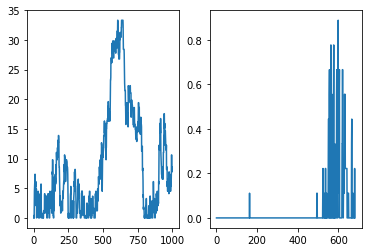

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.939
Episode: 11 Exploration P: 0.7992 Total reward: -4747.087638983379 SOC: 1.0000 Cumulative_SOC_deviation: 462.0277 Fuel Consumption: 126.8111

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 61.836
Episode: 12 Exploration P: 0.7826 Total reward: -3677.941465670475 SOC: 1.0000 Cumulative_SOC_deviation: 357.3657 Fuel Consumption: 104.2840

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 65.253
Episode: 13 Exploration P: 0.7660 Total reward: -3836.1322282427323 SOC: 1.0000 Cumulative_SOC_deviation: 374.8316 Fuel Consumption: 87.8165

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 112.516
Episode: 14 Exploration P: 0.7381 Total reward: -6546.33017002722 SOC: 1.0000 Cumulative_SOC_deviation: 638.3257 Fuel Consumption: 163.0732

../data/dr

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -838.182336624642 SOC: 0.3860 Cumulative_SOC_deviation: 83.6967 Fuel Consumption: 1.2156
******************* Test is done *****************



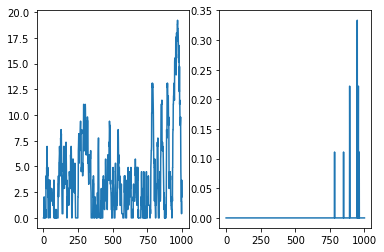

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.220
Episode: 21 Exploration P: 0.6190 Total reward: -4086.3405890694453 SOC: 1.0000 Cumulative_SOC_deviation: 398.1662 Fuel Consumption: 104.6787

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 62.251
Episode: 22 Exploration P: 0.6062 Total reward: -3180.68051750254 SOC: 1.0000 Cumulative_SOC_deviation: 309.8013 Fuel Consumption: 82.6675

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 62.032
Episode: 23 Exploration P: 0.5933 Total reward: -3584.5081680632475 SOC: 1.0000 Cumulative_SOC_deviation: 351.7968 Fuel Consumption: 66.5405

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 108.500
Episode: 24 Exploration P: 0.5719 Total reward: -5857.259353607793 SOC: 1.0000 Cumulative_SOC_deviation: 572.3933 Fuel Consumption: 133.3260

../data/dr

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -1842.1169038031508 SOC: 0.2761 Cumulative_SOC_deviation: 183.4958 Fuel Consumption: 7.1588
******************* Test is done *****************



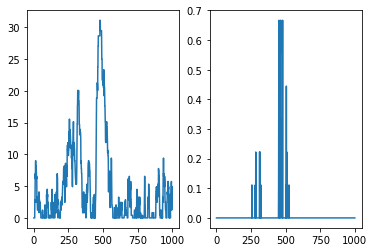

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 94.651
Episode: 31 Exploration P: 0.4799 Total reward: -3631.1292896522045 SOC: 1.0000 Cumulative_SOC_deviation: 353.9183 Fuel Consumption: 91.9461

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 91.834
Episode: 32 Exploration P: 0.4700 Total reward: -2284.874817115154 SOC: 0.9707 Cumulative_SOC_deviation: 220.8347 Fuel Consumption: 76.5282

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 90.996
Episode: 33 Exploration P: 0.4601 Total reward: -3475.4131451128296 SOC: 1.0000 Cumulative_SOC_deviation: 341.4331 Fuel Consumption: 61.0822

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 159.313
Episode: 34 Exploration P: 0.4436 Total reward: -4483.994675665287 SOC: 0.9125 Cumulative_SOC_deviation: 437.1233 Fuel Consumption: 112.7620

../data/dr

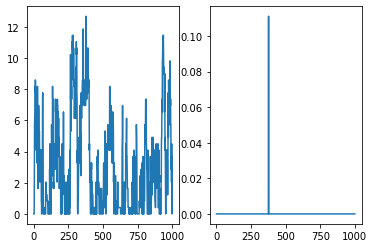

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 99.726
Episode: 41 Exploration P: 0.3726 Total reward: -2277.022182589291 SOC: 1.0000 Cumulative_SOC_deviation: 219.2732 Fuel Consumption: 84.2900

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 75.176
Episode: 42 Exploration P: 0.3650 Total reward: -1393.730684056693 SOC: 0.7465 Cumulative_SOC_deviation: 133.3072 Fuel Consumption: 60.6589

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 68.227
Episode: 43 Exploration P: 0.3573 Total reward: -2940.1856842494967 SOC: 1.0000 Cumulative_SOC_deviation: 289.0629 Fuel Consumption: 49.5568

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 115.768
Episode: 44 Exploration P: 0.3445 Total reward: -3393.3862797759343 SOC: 0.8681 Cumulative_SOC_deviation: 328.8270 Fuel Consumption: 105.1162

../data/dr

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -1095.0729309817461 SOC: 0.1506 Cumulative_SOC_deviation: 107.4635 Fuel Consumption: 20.4383
******************* Test is done *****************



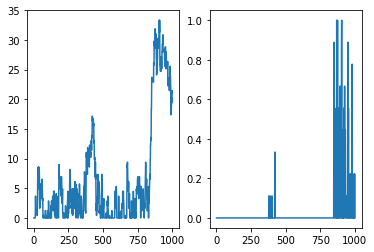

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 113.803
Episode: 51 Exploration P: 0.2898 Total reward: -771.7848239492597 SOC: 0.7513 Cumulative_SOC_deviation: 70.6336 Fuel Consumption: 65.4491

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 87.781
Episode: 52 Exploration P: 0.2839 Total reward: -957.0724077920974 SOC: 0.5743 Cumulative_SOC_deviation: 90.7743 Fuel Consumption: 49.3296

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 90.417
Episode: 53 Exploration P: 0.2780 Total reward: -2491.716141124303 SOC: 1.0000 Cumulative_SOC_deviation: 244.9846 Fuel Consumption: 41.8698

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 151.935
Episode: 54 Exploration P: 0.2682 Total reward: -1775.9362806394647 SOC: 0.4633 Cumulative_SOC_deviation: 169.9298 Fuel Consumption: 76.6382

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -2665.508211617054 SOC: 0.1123 Cumulative_SOC_deviation: 264.5627 Fuel Consumption: 19.8811
******************* Test is done *****************



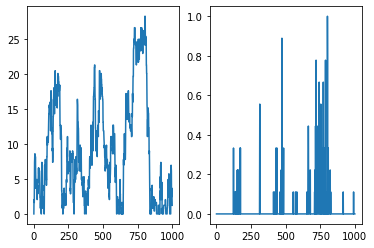

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 82.643
Episode: 61 Exploration P: 0.2259 Total reward: -1541.642739047092 SOC: 0.5011 Cumulative_SOC_deviation: 149.4663 Fuel Consumption: 46.9796

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 60.519
Episode: 62 Exploration P: 0.2214 Total reward: -1128.8005827204584 SOC: 0.4635 Cumulative_SOC_deviation: 108.7953 Fuel Consumption: 40.8481

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 64.142
Episode: 63 Exploration P: 0.2168 Total reward: -1398.9318449570658 SOC: 0.8501 Cumulative_SOC_deviation: 136.8546 Fuel Consumption: 30.3857

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 110.716
Episode: 64 Exploration P: 0.2092 Total reward: -2989.862351814837 SOC: 0.2864 Cumulative_SOC_deviation: 292.5059 Fuel Consumption: 64.8033

../data/dri

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 110.685
Episode: 69 Exploration P: 0.1850 Total reward: -4391.944851388657 SOC: 0.1348 Cumulative_SOC_deviation: 433.7604 Fuel Consumption: 54.3407

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 64.566
Episode: 70 Exploration P: 0.1812 Total reward: -1217.111929040012 SOC: 0.8009 Cumulative_SOC_deviation: 118.7077 Fuel Consumption: 30.0348

maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -696.9311246448261 SOC: 0.4699 Cumulative_SOC_deviation: 69.6737 Fuel Consumption: 0.1941
******************* Test is done *****************



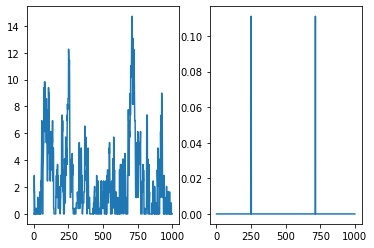

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.323
Episode: 71 Exploration P: 0.1766 Total reward: -2871.8127433124337 SOC: 0.3541 Cumulative_SOC_deviation: 283.5223 Fuel Consumption: 36.5893

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 62.988
Episode: 72 Exploration P: 0.1731 Total reward: -1450.2532552670098 SOC: 0.3069 Cumulative_SOC_deviation: 142.0580 Fuel Consumption: 29.6735

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 64.068
Episode: 73 Exploration P: 0.1696 Total reward: -1357.286629760322 SOC: 0.8472 Cumulative_SOC_deviation: 132.6891 Fuel Consumption: 30.3960

../data/driving_cycles/city\FTP_75_cycle.mat


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 111.963
Episode: 74 Exploration P: 0.1637 Total reward: -4409.950678746949 SOC: 0.1358 Cumulative_SOC_deviation: 435.5486 Fuel Consumption: 54.4645

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 64.642
Episode: 75 Exploration P: 0.1604 Total reward: -1043.619157777794 SOC: 0.7491 Cumulative_SOC_deviation: 101.7639 Fuel Consumption: 25.9798

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.389
Episode: 76 Exploration P: 0.1563 Total reward: -3243.6410533533103 SOC: 0.3098 Cumulative_SOC_deviation: 321.0240 Fuel Consumption: 33.4010

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 63.414
Episode: 77 Exploration P: 0.1533 Total reward: -1522.4311948055843 SOC: 0.2652 Cumulative_SOC_deviation: 149.5667 Fuel Consumption: 26.7638

../data/driving_cycles/city\07_manhattan.mat
maximum st

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 114.285
Episode: 79 Exploration P: 0.1450 Total reward: -5672.784528027523 SOC: 0.0518 Cumulative_SOC_deviation: 562.5089 Fuel Consumption: 47.6958

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 68.438
Episode: 80 Exploration P: 0.1421 Total reward: -958.8850338812256 SOC: 0.7325 Cumulative_SOC_deviation: 93.3679 Fuel Consumption: 25.2059

maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -767.7484385442989 SOC: 0.4379 Cumulative_SOC_deviation: 76.7647 Fuel Consumption: 0.1012
******************* Test is done *****************



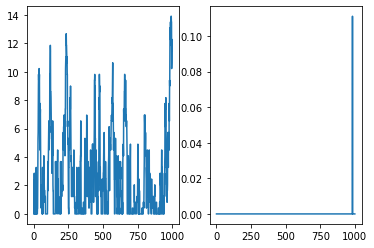

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 106.524
Episode: 81 Exploration P: 0.1386 Total reward: -3648.053499839031 SOC: 0.2557 Cumulative_SOC_deviation: 361.7748 Fuel Consumption: 30.3055

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 95.314
Episode: 82 Exploration P: 0.1359 Total reward: -1621.8327184924296 SOC: 0.2663 Cumulative_SOC_deviation: 159.4759 Fuel Consumption: 27.0733

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 109.439
Episode: 83 Exploration P: 0.1331 Total reward: -473.42427330578647 SOC: 0.7055 Cumulative_SOC_deviation: 45.4058 Fuel Consumption: 19.3659

../data/driving_cycles/city\FTP_75_cycle.mat


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 163.744
Episode: 84 Exploration P: 0.1286 Total reward: -6710.392666243591 SOC: -0.0088 Cumulative_SOC_deviation: 666.7330 Fuel Consumption: 43.0629

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 63.746
Episode: 85 Exploration P: 0.1261 Total reward: -601.9985278395086 SOC: 0.6752 Cumulative_SOC_deviation: 58.1735 Fuel Consumption: 20.2635

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 90.667
Episode: 86 Exploration P: 0.1229 Total reward: -4015.928016238869 SOC: 0.1991 Cumulative_SOC_deviation: 398.9636 Fuel Consumption: 26.2918

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 96.226
Episode: 87 Exploration P: 0.1206 Total reward: -1837.93539325374 SOC: 0.1795 Cumulative_SOC_deviation: 181.7115 Fuel Consumption: 20.8206

../data/driving_cycles/city\07_manhattan.mat
maximum steps

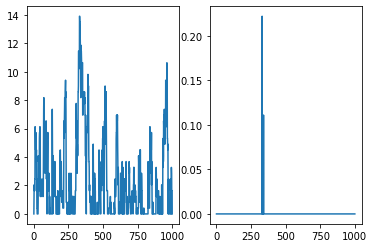

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 96.264
Episode: 91 Exploration P: 0.1092 Total reward: -1267.6952244160755 SOC: 0.6346 Cumulative_SOC_deviation: 121.0026 Fuel Consumption: 57.6696

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 68.244
Episode: 92 Exploration P: 0.1071 Total reward: -388.6764147878314 SOC: 0.6552 Cumulative_SOC_deviation: 33.7552 Fuel Consumption: 51.1247

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 79.132
Episode: 93 Exploration P: 0.1050 Total reward: -642.3280950147738 SOC: 0.7029 Cumulative_SOC_deviation: 62.3099 Fuel Consumption: 19.2291

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 119.412
Episode: 94 Exploration P: 0.1015 Total reward: -232.40485711079927 SOC: 0.6134 Cumulative_SOC_deviation: 15.1807 Fuel Consumption: 80.5979

../data/drivin

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -132.3310189438793 SOC: 0.5934 Cumulative_SOC_deviation: 11.7455 Fuel Consumption: 14.8759
******************* Test is done *****************



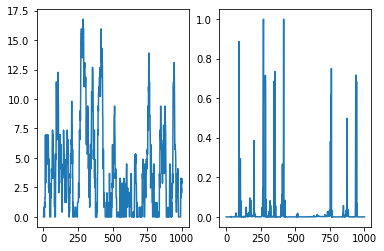

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 82.279
Episode: 101 Exploration P: 0.0865 Total reward: -211.6351446853553 SOC: 0.6007 Cumulative_SOC_deviation: 16.2187 Fuel Consumption: 49.4477

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 66.053
Episode: 102 Exploration P: 0.0849 Total reward: -157.50466135374415 SOC: 0.6055 Cumulative_SOC_deviation: 11.0934 Fuel Consumption: 46.5710

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 66.581
Episode: 103 Exploration P: 0.0833 Total reward: -294.6878244520574 SOC: 0.6753 Cumulative_SOC_deviation: 27.7329 Fuel Consumption: 17.3584

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 116.108
Episode: 104 Exploration P: 0.0806 Total reward: -368.20697188374913 SOC: 0.5889 Cumulative_SOC_deviation: 29.1739 Fuel Consumption: 76.4676

../data/dri

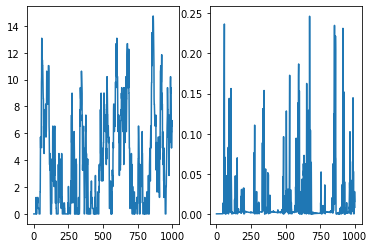

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.686
Episode: 111 Exploration P: 0.0691 Total reward: -110.00571556292083 SOC: 0.6095 Cumulative_SOC_deviation: 6.2396 Fuel Consumption: 47.6095

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 62.346
Episode: 112 Exploration P: 0.0678 Total reward: -156.941807582324 SOC: 0.6186 Cumulative_SOC_deviation: 11.1935 Fuel Consumption: 45.0068

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 64.014
Episode: 113 Exploration P: 0.0666 Total reward: -111.00211830876155 SOC: 0.6114 Cumulative_SOC_deviation: 9.9111 Fuel Consumption: 11.8912

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 112.538
Episode: 114 Exploration P: 0.0645 Total reward: -182.25535615066053 SOC: 0.6125 Cumulative_SOC_deviation: 10.6745 Fuel Consumption: 75.5099

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 48989.642415712384(+) but condition is not avail
******************* Test is start *****************
Total reward: -1030.717494618662 SOC: 0.5988 Cumulative_SOC_deviation: 1.0944 Fuel Consumption: 20.6213
******************* Test is done *****************



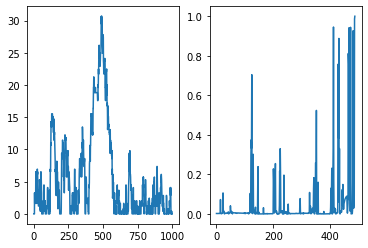

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.345
Episode: 121 Exploration P: 0.0556 Total reward: -120.74347363835238 SOC: 0.6044 Cumulative_SOC_deviation: 7.3621 Fuel Consumption: 47.1226

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 61.842
Episode: 122 Exploration P: 0.0546 Total reward: -149.8143598684183 SOC: 0.6177 Cumulative_SOC_deviation: 10.5627 Fuel Consumption: 44.1877

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 62.656
Episode: 123 Exploration P: 0.0537 Total reward: -66.45221945972906 SOC: 0.6046 Cumulative_SOC_deviation: 5.5221 Fuel Consumption: 11.2307

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 109.103
Episode: 124 Exploration P: 0.0521 Total reward: -189.01449548303864 SOC: 0.6009 Cumulative_SOC_deviation: 11.3692 Fuel Consumption: 75.3225

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -29.576606041447413 SOC: 0.5943 Cumulative_SOC_deviation: 1.8638 Fuel Consumption: 10.9391
******************* Test is done *****************



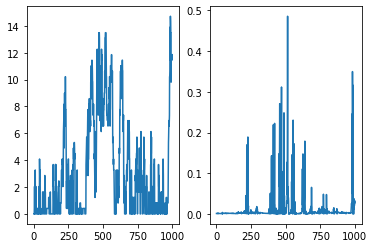

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.385
Episode: 131 Exploration P: 0.0452 Total reward: -106.54066500486314 SOC: 0.6002 Cumulative_SOC_deviation: 6.0468 Fuel Consumption: 46.0723

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 62.793
Episode: 132 Exploration P: 0.0444 Total reward: -157.0699942876814 SOC: 0.6184 Cumulative_SOC_deviation: 11.2161 Fuel Consumption: 44.9093

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 64.201
Episode: 133 Exploration P: 0.0437 Total reward: -45.564327894368404 SOC: 0.5914 Cumulative_SOC_deviation: 3.5575 Fuel Consumption: 9.9895

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 110.332
Episode: 134 Exploration P: 0.0424 Total reward: -228.65404626014387 SOC: 0.5995 Cumulative_SOC_deviation: 15.4875 Fuel Consumption: 73.7788

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -35.951643002967906 SOC: 0.5980 Cumulative_SOC_deviation: 1.8406 Fuel Consumption: 17.5456
******************* Test is done *****************



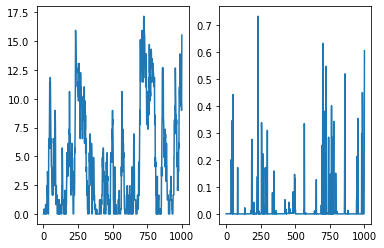

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.668
Episode: 141 Exploration P: 0.0371 Total reward: -127.27782102698846 SOC: 0.5986 Cumulative_SOC_deviation: 8.1422 Fuel Consumption: 45.8554

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 61.599
Episode: 142 Exploration P: 0.0366 Total reward: -155.01207386919214 SOC: 0.6109 Cumulative_SOC_deviation: 11.0950 Fuel Consumption: 44.0622

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 63.133
Episode: 143 Exploration P: 0.0360 Total reward: -53.33608838119845 SOC: 0.6029 Cumulative_SOC_deviation: 4.2567 Fuel Consumption: 10.7688

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 131.323
Episode: 144 Exploration P: 0.0350 Total reward: -200.79865412492856 SOC: 0.6024 Cumulative_SOC_deviation: 12.7248 Fuel Consumption: 73.5509

../data/driv

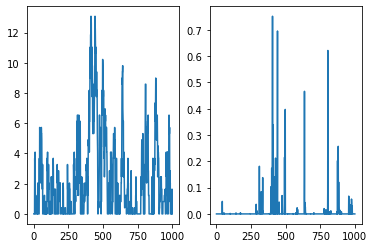

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 132.308
Episode: 151 Exploration P: 0.0309 Total reward: -167.52450929582227 SOC: 0.5962 Cumulative_SOC_deviation: 12.1849 Fuel Consumption: 45.6751

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 99.319
Episode: 152 Exploration P: 0.0305 Total reward: -115.64962813475526 SOC: 0.6037 Cumulative_SOC_deviation: 7.2914 Fuel Consumption: 42.7356

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 95.434
Episode: 153 Exploration P: 0.0301 Total reward: -75.62706890426598 SOC: 0.5957 Cumulative_SOC_deviation: 6.6049 Fuel Consumption: 9.5783

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 128.325
Episode: 154 Exploration P: 0.0293 Total reward: -263.3997560560607 SOC: 0.6000 Cumulative_SOC_deviation: 19.0442 Fuel Consumption: 72.9581

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -81.86984110675961 SOC: 0.5881 Cumulative_SOC_deviation: 6.7737 Fuel Consumption: 14.1333
******************* Test is done *****************



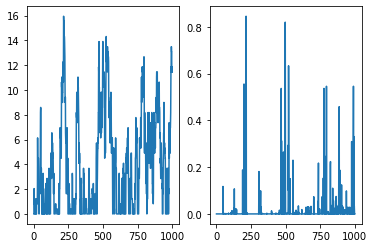

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 85.826
Episode: 161 Exploration P: 0.0262 Total reward: -173.67873014117626 SOC: 0.5966 Cumulative_SOC_deviation: 12.8256 Fuel Consumption: 45.4230

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 63.109
Episode: 162 Exploration P: 0.0258 Total reward: -126.9422959800942 SOC: 0.6105 Cumulative_SOC_deviation: 8.3568 Fuel Consumption: 43.3740

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 63.705
Episode: 163 Exploration P: 0.0255 Total reward: -80.38229277714096 SOC: 0.5955 Cumulative_SOC_deviation: 7.0641 Fuel Consumption: 9.7416

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 109.438
Episode: 164 Exploration P: 0.0249 Total reward: -293.6416432985596 SOC: 0.5973 Cumulative_SOC_deviation: 22.1228 Fuel Consumption: 72.4140

../data/driving

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -141.76154429245054 SOC: 0.5877 Cumulative_SOC_deviation: 11.5464 Fuel Consumption: 26.2977
******************* Test is done *****************



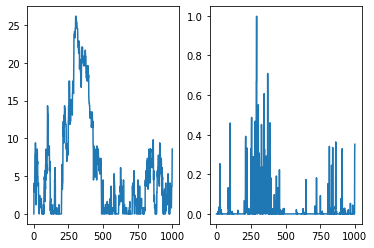

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 107.665
Episode: 171 Exploration P: 0.0225 Total reward: -199.5582210422094 SOC: 0.5963 Cumulative_SOC_deviation: 15.4150 Fuel Consumption: 45.4078

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 83.404
Episode: 172 Exploration P: 0.0222 Total reward: -145.97556366734128 SOC: 0.6159 Cumulative_SOC_deviation: 10.2086 Fuel Consumption: 43.8899

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 85.584
Episode: 173 Exploration P: 0.0219 Total reward: -74.39513172695392 SOC: 0.5924 Cumulative_SOC_deviation: 6.4739 Fuel Consumption: 9.6558

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 146.537
Episode: 174 Exploration P: 0.0215 Total reward: -240.78963158372972 SOC: 0.5976 Cumulative_SOC_deviation: 16.8196 Fuel Consumption: 72.5940

../data/driv

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -47.61436236738013 SOC: 0.5980 Cumulative_SOC_deviation: 3.5310 Fuel Consumption: 12.3042
******************* Test is done *****************



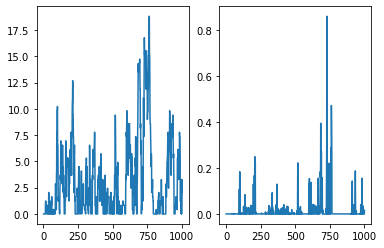

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.380
Episode: 181 Exploration P: 0.0196 Total reward: -117.15049134468903 SOC: 0.6008 Cumulative_SOC_deviation: 7.0759 Fuel Consumption: 46.3914

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 62.116
Episode: 182 Exploration P: 0.0194 Total reward: -127.1738898057945 SOC: 0.6132 Cumulative_SOC_deviation: 8.3845 Fuel Consumption: 43.3288

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 65.048
Episode: 183 Exploration P: 0.0192 Total reward: -39.21166356646262 SOC: 0.5990 Cumulative_SOC_deviation: 2.8890 Fuel Consumption: 10.3221

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 111.679
Episode: 184 Exploration P: 0.0189 Total reward: -163.7718512218904 SOC: 0.6076 Cumulative_SOC_deviation: 9.0618 Fuel Consumption: 73.1536

../data/driving_

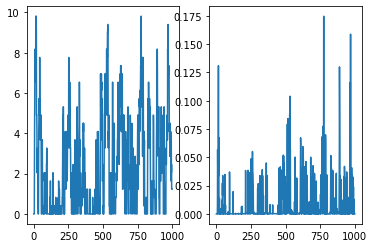

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.851
Episode: 191 Exploration P: 0.0174 Total reward: -116.81623358536945 SOC: 0.6032 Cumulative_SOC_deviation: 7.0725 Fuel Consumption: 46.0917

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 62.042
Episode: 192 Exploration P: 0.0173 Total reward: -127.85792907680063 SOC: 0.6038 Cumulative_SOC_deviation: 8.5314 Fuel Consumption: 42.5438

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 64.353
Episode: 193 Exploration P: 0.0171 Total reward: -42.935868738870575 SOC: 0.5970 Cumulative_SOC_deviation: 3.3300 Fuel Consumption: 9.6364

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 110.550
Episode: 194 Exploration P: 0.0168 Total reward: -193.5181610532284 SOC: 0.6048 Cumulative_SOC_deviation: 12.0079 Fuel Consumption: 73.4387

../data/drivin

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -81.97170370317174 SOC: 0.5928 Cumulative_SOC_deviation: 6.9173 Fuel Consumption: 12.7983
******************* Test is done *****************



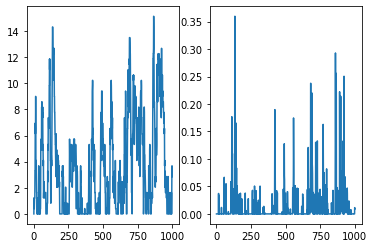

model is saved..


In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:5]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes):
        i = ep % len(driving_cycle_paths)
        driving_cycle_path =driving_cycle_paths[i]
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]

        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG_reference_trained_five_mass1200"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_reference_five_mass1200.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict